In [1]:
library(ggplot2)
library(mvtnorm)
options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 100)

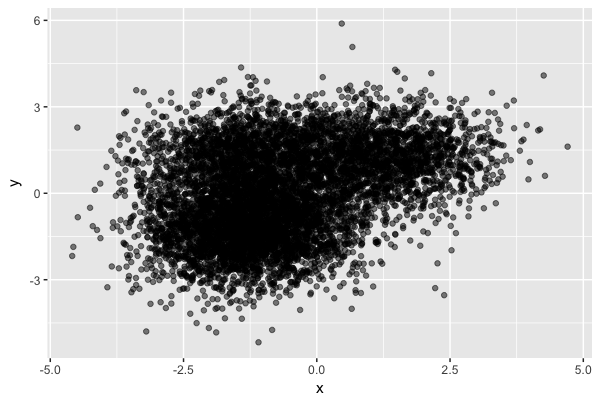

In [304]:
# Generate some data using a mixture model
p1 <- rmvnorm(7500, mean = c(-1.25, -1.25), sigma = diag(2))
p2 <- rmvnorm(7500, mean = c(1.25, 1.25), sigma = diag(2))
p3 <- rmvnorm(7500, mean = c(-1.25, 1.25), sigma = diag(2))
cat <- sample(0:2, 7500, replace = TRUE, prob = c(.5, .25, .25))
df <- data.frame(((cat == 0) * p1) + ((cat == 1) * p2) + ((cat == 2) * p3))
colnames(df) <- c('x', 'y')

ggplot(df, aes(x = x, y = y)) +
  geom_point(alpha = 0.5)

In [319]:
em.fit <- function(df, n.clusters = 2, n.iters = 100) {
    # Computes the responsibility
    .compute_rk <- function(k) {
        theta$pi[k] * dmvnorm(df, mean = theta$mu[, k], sigma = theta$sigma[[k]])
    }
    .compute_muk <- function(k) {
        colSums(resp[, k] * df, na.rm = TRUE) / sum(resp[, k], na.rm = TRUE)
    }
    .compute_covk <- function(k) {
        val <- lapply(1:nrow(df), function(x) resp[x, k] * (matrix(df[x, ]) %*% t(matrix(df[x, ]))))
        val <- Reduce('+', val) / sum(resp[, k], na.rm = TRUE)
        mu.diff <- mu.k[, k] %*% t(mu.k[, k])
        return(val - mu.diff)
    }
    df <- as.matrix(df)
    
    # Initialize the parameters
    clusters <- sample(1:n.clusters, nrow(df.m), replace = TRUE,
                       prob = rep(1 / n.clusters, n.clusters))
    theta <- list(pi = rep(n.clusters, n.clusters) / (n.clusters ^ 2),
                  mu = matrix(rnorm(ncol(df) * n.clusters), nrow = ncol(df), ncol = n.clusters),
                  sigma = lapply(1:n.clusters, function(x) diag(ncol(df))),
                  n.clusters = n.clusters)
    
    if (n.iters == 0)
        return(theta)
    
    for (i in 0:n.iters) {
        # Do the E-step
        resp <- do.call(cbind, lapply(1:n.clusters, .compute_rk))
        resp <- resp / rowSums(resp)
    
        # Do the M-step
        pi.k <- colMeans(resp)
        mu.k <- do.call(cbind, lapply(1:n.clusters, .compute_muk))
        cov.k <- lapply(1:n.clusters, .compute_covk)
        theta <- list(pi = pi.k, mu = mu.k, sigma = cov.k, n.clusters = n.clusters)
    }
    
    return(theta)
}

em.predict <- function(theta, newdata) {
    .compute_rk <- function(k) {
        theta$pi[k] * dmvnorm(newdata, mean = theta$mu[, k], sigma = theta$sigma[[k]])
    }
    
    resp <- do.call(cbind, lapply(1:theta$n.clusters, .compute_rk))
    resp <- resp / rowSums(resp)
    yhat <- apply(resp, 1, which.max)
    return(yhat)
}

df <- data.frame(((cat == 0) * p1) + ((cat == 1) * p2) + ((cat == 2) * p3))
colnames(df) <- c('x', 'y')
theta <- em.fit(df, n.clusters = 3, n.iters = 100)

preds <- em.predict(theta, df)
df$predicted.cluster <- factor(preds)

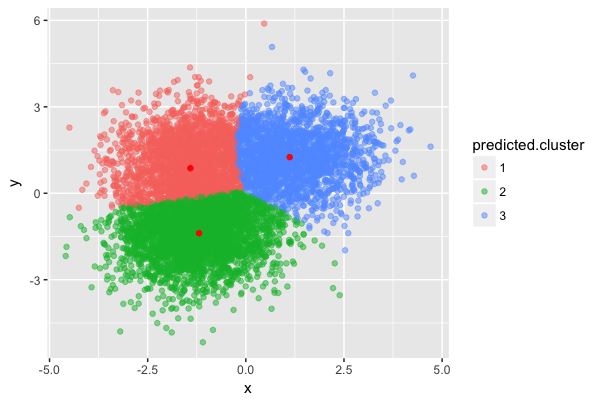

In [320]:
ggplot(df, aes(x = x, y = y, color = predicted.cluster)) +
  geom_point(alpha = 0.5) +
  geom_point(data = as.data.frame(t(theta$mu)),
             color = 'red', aes(x = x, y = y))